<a href="https://colab.research.google.com/github/asanth7/SP500-news-prediction/blob/main/KERAS_FinalBERT_StockPrediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! echo "Installing Magnitude.... (please wait, can take a while)"
! (curl https://raw.githubusercontent.com/plasticityai/magnitude/master/install-colab.sh | /bin/bash 1>/dev/null 2>/dev/null)
! echo "Done installing Magnitude."

Installing Magnitude.... (please wait, can take a while)
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   137  100   137    0     0    717      0 --:--:-- --:--:-- --:--:--   721


In [ ]:
!pip install transformers==4.9.0
# !pip install --upgrade tensorflow
# !pip install pytorch_warmup

In [ ]:
!pip3 install tensorflow==2.8
!pip3 install keras==2.8
!pip3 install -U segmentation-models

In [ ]:
import torch
from torch import nn
from torch import optim
import pytorch_warmup as warmup
import pandas as pd
import numpy as np
from tqdm import tqdm
from transformers import BertTokenizer, BertForSequenceClassification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from official.nlp import optimization  # to create AdamW optimizer

In [ ]:
df = pd.read_csv('/content/S&P500_RedditNews_labeled_data_INCREMENTED_LABELS.csv')
df = df.dropna()
df.head()

In [ ]:
new_df = pd.DataFrame(columns=['Label', 'Headline'])

for row in range(len(df)):
  label = df.iloc[row]['Label']
  for i in range(1, 26):
    headline = df.iloc[row][i]
    new_df = new_df.append({'Label': label, 'Headline': headline}, ignore_index=True)

new_df

In [ ]:
int_labels = [int(label) for label in new_df.Label.tolist()]
# Find the name of the column by index

new_df['Int_label'] = int_labels
del new_df['Label']

new_df.head()

In [ ]:
new_df.groupby(['Int_label']).size().plot.bar()

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

example_text = 'Programming is a very challenging yet rewarding activity'
bert_input = tokenizer(example_text,padding='max_length', max_length = 10,
                       truncation=True, return_tensors="pt")


print(bert_input['input_ids'])
print(bert_input['token_type_ids'])
print(bert_input['attention_mask'])


In [ ]:
train_df, test_df = train_test_split(new_df, test_size=0.2)
train_df, val_df = train_test_split(train_df, test_size=0.2)
train_df.shape, val_df.shape, test_df.shape
train_df.head()

KERAS BERT

In [ ]:
!pip install transformers
!pip install --upgrade tensorflow

In [ ]:
!pip install tensorflow_addons

In [ ]:
import transformers
from transformers import BertTokenizer, TFBertModel, BertConfig, TFBertForSequenceClassification
bert_tokenizer = BertTokenizer.from_pretrained("bert-base-cased") #feel free to change the model
bert_model = TFBertForSequenceClassification.from_pretrained('bert-base-cased',num_labels=8)

In [ ]:
def BERT_Tokenizer(sentences):
  '''Input: list of sentences
     Output: two numpy array
  '''

  idList = []
  maskList = []
  for sentence in sentences:
    encoding = bert_tokenizer.encode_plus(sentence, add_special_tokens = True,
                                              max_length=64,pad_to_max_length = True,
                                              return_attention_mask = True)
    idList.append(encoding['input_ids'])
    maskList.append(encoding['attention_mask'])

  return np.array(idList), np.array(maskList)

X_train_ids, X_train_masks = BERT_Tokenizer(train_df.Headline)
X_val_ids, X_val_masks = BERT_Tokenizer(val_df.Headline)
y_train_array = np.array(train_df.Int_label)
layer = keras.layers.CategoryEncoding(num_tokens=8, output_mode="one_hot")
one_hot_y_train = layer(y_train_array)
print('One_hot_y_train shape: ' + str(one_hot_y_train.shape))
y_val_array = np.array(val_df.Int_label)
one_hot_y_val = layer(y_val_array)
print('One_hot_y_val shape: ' + str(one_hot_y_val.shape))
assert X_train_ids.shape[-1] == 64

In [ ]:
!pip install tensorflow_addons

Time-Based LRS

In [ ]:
import tensorflow as tf
from tensorflow_addons.optimizers import AdamW

epochs = 5
learning_rate = 0.1
decay_rate = learning_rate / epochs
momentum = 0.8
optimizer = AdamW(lr=learning_rate, weight_decay=decay_rate)

bert_model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
bert_model.fit([X_train_ids, X_train_masks], y_train_array, epochs=epochs, batch_size=50, validation_data = ([X_val_ids, X_val_masks], y_val_array),
          verbose=1)

**Training GloVe Model**

In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip

In [ ]:
!pip install -q tf-models-official==2.7.0

In [ ]:
import keras
import tensorflow as tf
from keras.preprocessing.text import Tokenizer
from keras.optimizers import rmsprop_v2
from keras import layers
from keras.layers import TextVectorization, Embedding, Dropout, MaxPooling1D, GlobalMaxPooling1D, BatchNormalization, Dense, Conv1D
import numpy as np
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from official.nlp import optimization  # to create AdamW optimizer

In [ ]:
df = pd.read_csv('/content/S&P500_RedditNews_labeled_data_final4.csv')
df = df.dropna()
df.head()

In [ ]:
def createVocab(df):

  new_df = pd.DataFrame(columns=['Label', 'Headline'])

  for row in range(len(df)):
    label = df.iloc[row]['Label']
    for i in range(1, 26):
      headline = df.iloc[row][i]
      new_df = new_df.append({'Label': label, 'Headline': headline}, ignore_index=True)

  train_df, test_df = train_test_split(new_df, test_size=0.2)
  train_df, val_df = train_test_split(train_df, test_size=0.2)

  print(train_df.shape, val_df.shape, test_df.shape)

  headlines = []
  for headline in train_df['Headline'].tolist():
    headlines.append(headline)
  for headline in val_df['Headline'].tolist():
    headlines.append(headline)

  train_labels = [int(label) for label in train_df.Label.tolist()]
  val_labels = [int(label) for label in val_df.Label.tolist()]
  test_labels = [int(label) for label in test_df.Label.tolist()]

  print(new_df.groupby(['Label']).size().plot.bar())

  return headlines, train_labels, val_labels, test_labels, train_df, val_df, test_df

headlines, train_labels, val_labels, test_labels, train_df, val_df, test_df = createVocab(df)

In [ ]:
vectorizer = TextVectorization(max_tokens=20000, output_sequence_length=300)
text_ds = tf.data.Dataset.from_tensor_slices(headlines).batch(64)
vectorizer.adapt(text_ds)

vectorizer.get_vocabulary()[:5]

In [ ]:
vocab = vectorizer.get_vocabulary()
word2idx = dict(zip(vocab, range(len(vocab))))

In [ ]:
output = vectorizer(['the cat sat on the mat'])
output.numpy()[0, :6]

In [ ]:
test = ['the cat sat on the mat']
[word2idx[word] for word in test[0].split()]

In [ ]:
# Embedding dict mapping words to NumPy vectorized representation

glove_300d = '/content/glove.6B.300d.txt'
glove_200d = '/content/glove.6B.200d.txt'

embeddings_index = {}
with open(glove_300d) as f:
  for line in f:
      word, coefs = line.split(maxsplit=1)
      coefs = np.fromstring(coefs, "f", sep=" ")
      embeddings_index[word] = coefs
  print(line)

print("Found %s word vectors." % len(embeddings_index))

In [ ]:
num_tokens = len(vocab) + 2
embedding_dim = 300
vector_exists = 0
vector_nonexistant = 0

# Prepare embedding matrix
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in word2idx.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        vector_exists += 1
    else:
        vector_nonexistant += 1
print("%d embedding vectors for words found, %d words not found in embedding index" % (vector_exists, vector_nonexistant))


In [ ]:
glove_embedding_layer = Embedding(
    num_tokens,
    embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    trainable=False)

In [ ]:
print(np.array(headlines).shape)
print(np.array(train_labels).shape)

In [ ]:
from sklearn.utils.class_weight import compute_class_weight

def set_class_weights():
    class_weights = compute_class_weight('balanced', classes=np.unique(train_labels), y=train_labels)
    class_weights = dict(enumerate(class_weights))
    print('Class weights:', class_weights)
    return class_weights

class_weights = set_class_weights()

In [ ]:
def build_embedding_classifier_model(embedding_dim, output_bias=None):

  if output_bias is not None:
    output_bias = tf.keras.initializers.Constant(output_bias)

  str_sequences_input = keras.Input(shape=(embedding_dim,))
  embedded_sequences = glove_embedding_layer(str_sequences_input)
  x = layers.Conv1D(64, 7, input_shape=[None, str_sequences_input])(embedded_sequences)
  #x = Dropout(0.05)(x)
  #x = layers.MaxPooling1D(3)(x)
  x = layers.Conv1D(128, 7)(x)
  #x = Dropout(0.05)(x)
  #x = layers.MaxPooling1D(3)(x)
  x = layers.Conv1D(64, 7)(x)
  #x = Dropout(0.05)(x)
  #x = layers.MaxPooling1D(3)(x)
  x = layers.Conv1D(32, 7)(x)
  #x = Dropout(0.05)(x)
  x = layers.GlobalMaxPooling1D()(x)
  x = layers.BatchNormalization()(x)
  x = layers.Dense(32, activation="relu")(x)
  x = layers.Dropout(0.15)(x)
  preds = layers.Dense(len(list(np.unique(train_labels))), activation='softmax')(x)
  model = keras.Model(str_sequences_input, preds)
  print(model.summary())

  return model

embedding_stock_model = build_embedding_classifier_model(embedding_dim)

In [ ]:
train_headlines = vectorizer(np.array([[headline] for headline in train_df['Headline']])).numpy()
val_headlines = vectorizer(np.array([[headline] for headline in val_df['Headline']])).numpy()
test_headlines = vectorizer(np.array([[headline] for headline in test_df['Headline']])).numpy()

train_labels = np.array(train_labels)
val_labels = np.array(val_labels)
test_labels = np.array(test_labels)

In [ ]:
loss = keras.losses.SparseCategoricalCrossentropy(from_logits=False)
#loss = keras.losses.KLDivergence()
metrics = tf.metrics.SparseCategoricalAccuracy()

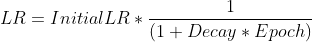

In [ ]:
import math

def lr_time_based_decay(epoch, lr):
  decay = 0
  if epoch is not 0:
    decay = lr / epoch
  return lr / (1 + decay * epoch)

def lr_exp_decay(epoch, lr):
    k = 0.2
    return lr * math.exp(-k*epoch)

In [ ]:
epochs = 15
batch_size = 20
#steps_per_epoch = tf.data.experimental.cardinality(train_df).numpy()
steps_per_epoch = len(train_df) // batch_size
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

earlystop = tf.keras.callbacks.EarlyStopping(patience=5)
lr_time_based_decay = tf.keras.callbacks.LearningRateScheduler(lr_time_based_decay)
lr_exp_decay_callback = tf.keras.callbacks.LearningRateScheduler(lr_exp_decay)

# MODEL 1: init_lr 3e-5, epochs = 5
# MODEL 2: init_lr = 5e-5, epochs = 5
# MODEL 3: init_lr = 5e-5, epochs = 10
# MODEL 5: init_lr = 4e-5
# MODEL 6: init_lr = 3e-5

In [ ]:
embedding_stock_model.compile(loss=loss, optimizer=optimizer, metrics=[metrics])
embedding_stock_model.fit(train_headlines, train_labels, validation_data=(val_headlines, val_labels),
                          class_weight=class_weights, batch_size=batch_size, epochs=epochs, callbacks=[earlystop])

In [ ]:
tf.keras.utils.plot_model(embedding_stock_model, show_shapes=True, show_layer_names=True)

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.utils import to_categorical

y_pred = np.array(embedding_stock_model.predict(test_headlines))
#y_pred = y_pred.flatten()
#print(test_df['Headline'].tolist()[:10])
#p_pred = p_pred.round(2)

y_pred = np.where(y_pred > 0.5, 1, 0)

y_pred_final = np.array([label for label in y_pred])
y_test = np.array(to_categorical(y=test_labels.tolist(), num_classes=6))

labels = [str(label) for label in np.unique(test_labels)]
#labels = ["0", "1"]

cm = confusion_matrix(y_test.argmax(axis=1), y_pred_final.argmax(axis=1))

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

disp.plot(cmap=plt.cm.Blues)
plt.show()

In [ ]:
# BEST MULTICLASS - 45%

# def build_embedding_classifier_model(embedding_dim, output_bias=None):

#   if output_bias is not None:
#     output_bias = tf.keras.initializers.Constant(output_bias)

#   str_sequences_input = keras.Input(shape=(embedding_dim,))
#   embedded_sequences = glove_embedding_layer(str_sequences_input)
#   x = layers.Conv1D(64, 7, input_shape=[None, str_sequences_input])(embedded_sequences)
#   #x = Dropout(0.05)(x)
#   x = layers.MaxPooling1D(3)(x)
#   x = layers.Conv1D(128, 7)(x)
#   #x = Dropout(0.05)(x)
#   x = layers.MaxPooling1D(3)(x)
#   x = layers.Conv1D(64, 7)(x)
#   #x = Dropout(0.05)(x)
#   x = layers.MaxPooling1D(3)(x)
#   x = layers.Conv1D(32, 7)(x)
#   #x = Dropout(0.05)(x)
#   x = layers.GlobalMaxPooling1D()(x)
#   x = layers.BatchNormalization()(x)
#   x = layers.Dense(8, activation="relu")(x)
#   x = layers.Dropout(0.15)(x)
#   preds = layers.Dense(len(list(np.unique(train_labels))), activation='softmax')(x)
#   model = keras.Model(str_sequences_input, preds)
#   print(model.summary())

#   return model

# embedding_stock_model = build_embedding_classifier_model(embedding_dim)

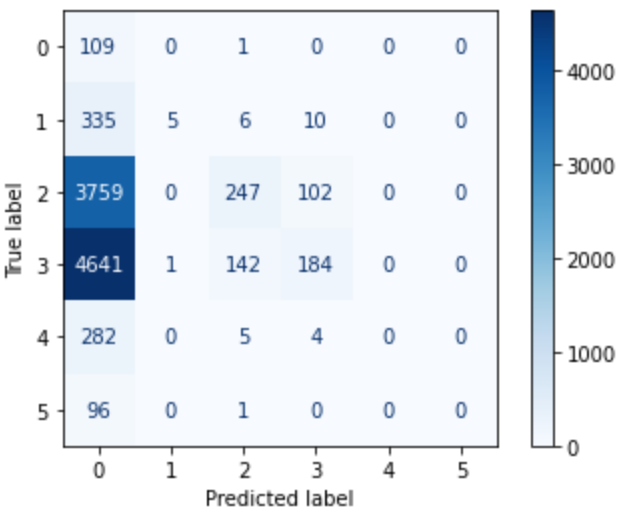

In [ ]:
# # BEST BINARY - 51%

# def build_embedding_classifier_model(embedding_dim, output_bias=None):

#   if output_bias is not None:
#     output_bias = tf.keras.initializers.Constant(output_bias)

#   str_sequences_input = keras.Input(shape=(embedding_dim,))
#   embedded_sequences = glove_embedding_layer(str_sequences_input)
#   x = layers.Conv1D(64, 7, input_shape=[None, str_sequences_input])(embedded_sequences)
#   #x = Dropout(0.05)(x)
#   x = layers.MaxPooling1D(3)(x)
#   x = layers.Conv1D(128, 7)(x)
#   #x = Dropout(0.05)(x)
#   x = layers.MaxPooling1D(3)(x)
#   x = layers.Conv1D(64, 7)(x)
#   #x = Dropout(0.05)(x)
#   x = layers.MaxPooling1D(3)(x)
#   x = layers.Conv1D(32, 7)(x)
#   #x = Dropout(0.05)(x)
#   x = layers.GlobalMaxPooling1D()(x)
#   x = layers.BatchNormalization()(x)
#   x = layers.Dense(8, activation="relu")(x)
#   x = layers.Dropout(0.15)(x)
#   preds = layers.Dense(len(list(np.unique(train_labels))), activation='softmax')(x)
#   model = keras.Model(str_sequences_input, preds)
#   print(model.summary())

#   return model

# embedding_stock_model = build_embedding_classifier_model(embedding_dim)

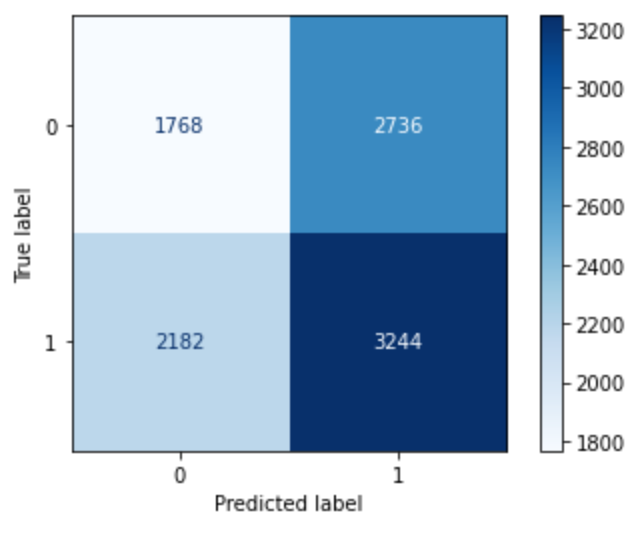